In [1]:
#Import libraries
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

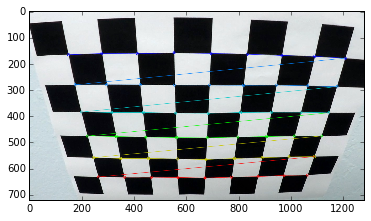

In [2]:
#Finding corners in a one image (for testing)
nx = 9
ny = 6

# Make a list of calibration images
fname = 'camera_cal/calibration2.jpg'
img = cv2.imread(fname)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)


In [3]:
# Make a list of calibration images
calibration_images = glob.glob('camera_cal/calibration*.jpg')

In [4]:
def get_img_obj_points():
    # prepare object points
    nx = 9
    ny = 6

    #Array to store object points and image points from all the images
    objPoints = [] #3D points
    imgPoints = [] #2D points

    #Prepare object points like (0,0,0), (1,0,0) to (8,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) #x, y coordinates

    for image in calibration_images:
        img = mpimg.imread(image)

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    #     print (ret)

        # If found, draw corners
        if ret == True:
            imgPoints.append(corners)
            objPoints.append(objp)
    return imgPoints, objPoints

def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [5]:
imgPoints, objPoints = get_img_obj_points()

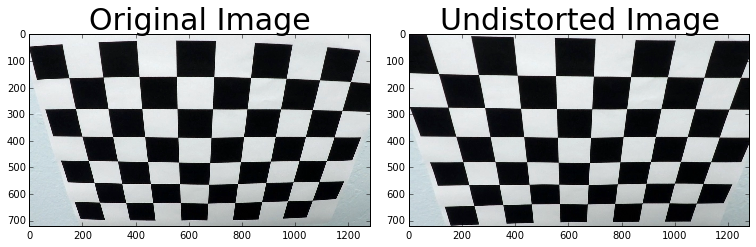

In [6]:
test_img='camera_cal/calibration2.jpg'

# Read in an image
img = cv2.imread(test_img)
undistorted = cal_undistort(img, objPoints, imgPoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [115]:
def get_undistorted_images(images):
    undistorted_images = []
    for image in images:
        img = cv2.imread(image)
        undistort = cal_undistort(img, objPoints, imgPoints)
        undistorted_images.append(undistort)
    return undistorted_images

undistorted_images = get_undistorted_images(calibration_images)    

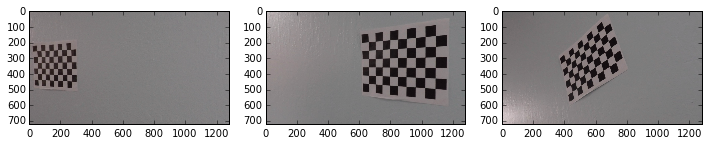

In [8]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
f.tight_layout()
ax1.imshow(undistorted_images[2])
ax2.imshow(undistorted_images[3])
ax3.imshow(undistorted_images[4])

In [9]:
#load test images
# test_images_files = glob.glob('test_images/*.jpg')
test_images = glob.glob('test_images/*.jpg')

In [10]:
test_undistorted = get_undistorted_images(test_images)

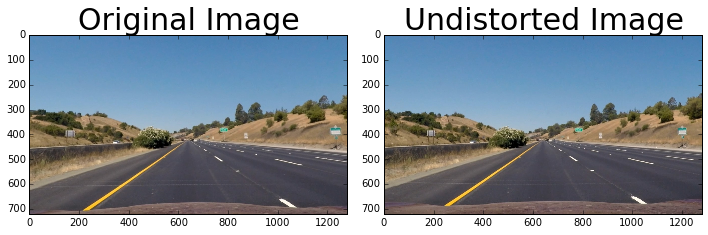

In [11]:
test_undistorted_rgb = []
for image in test_undistorted:
    test_undistorted_rgb.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
f.tight_layout()
ax1.imshow(test_undistorted_rgb[0])
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(cv2.imread(test_images[0]), cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)

## Absolute Threshold, Magnitude Threshold, Direction threshold

In [226]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1,0,ksize = sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0,1,ksize = sobel_kernel)
    mag = np.absolute(sobel)
    scaled_sobel = np.uint8(255*mag/np.max(mag))
    grad_binary =  np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0,ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1,ksize = sobel_kernel)
    grad_mag = np.sqrt(sobelx**2+sobely**2)
    scaled_sobel = np.uint8(255*grad_mag/np.max(grad_mag))
    mag_binary =  np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0,ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1,ksize = sobel_kernel)
    magx = np.absolute(sobelx)
    magy = np.absolute(sobely)
    grad_dir = np.arctan2(magy, magx)
    dir_binary =  np.zeros_like(grad_dir)
    dir_binary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    return dir_binary

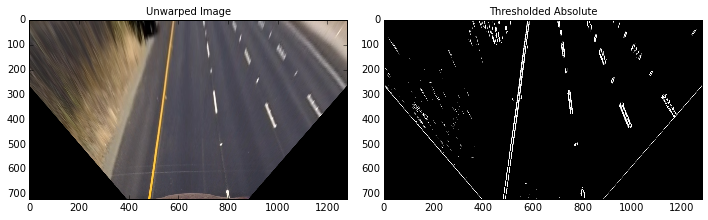

In [227]:
ksize = 3
sobelabs_unwarp_x = abs_sobel_thresh(unwarped, 'x', thresh=(25, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
f.tight_layout()
ax1.imshow(unwarped)
ax1.set_title('Unwarped Image', fontsize=10)
ax2.imshow(sobelabs_unwarp_x, cmap='gray')
ax2.set_title('Thresholded Absolute', fontsize=10)

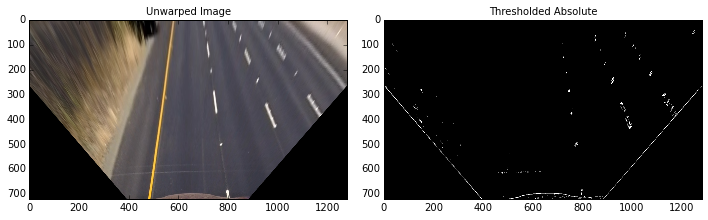

In [228]:
ksize = 3
sobelabs_unwarp_y = abs_sobel_thresh(unwarped, orient='y', sobel_kernel=ksize, thresh=(30, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
f.tight_layout()
ax1.imshow(unwarped)
ax1.set_title('Unwarped Image', fontsize=10)
ax2.imshow(sobelabs_unwarp_y, cmap='gray')
ax2.set_title('Thresholded Absolute', fontsize=10)

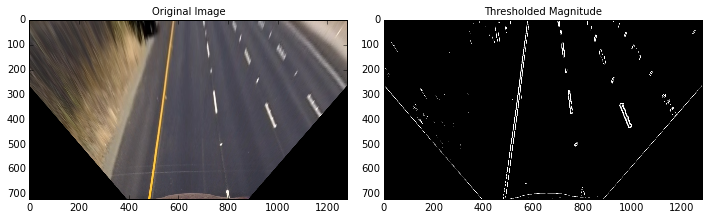

In [229]:
mag_binary = mag_thresh(unwarped, sobel_kernel=ksize, mag_thresh=(30, 100))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
f.tight_layout()
ax1.imshow(unwarped)
ax1.set_title('Original Image', fontsize=10)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=10)

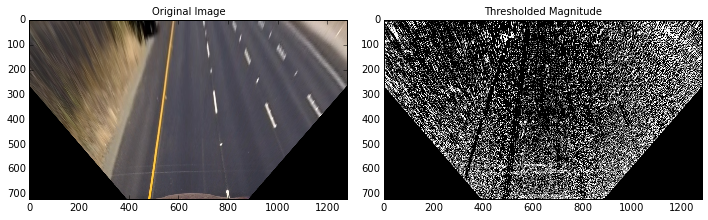

In [230]:
dir_binary = dir_threshold(unwarped, sobel_kernel=ksize, thresh=(0.7, 1.4))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
f.tight_layout()
ax1.imshow(unwarped)
ax1.set_title('Original Image', fontsize=10)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=10)

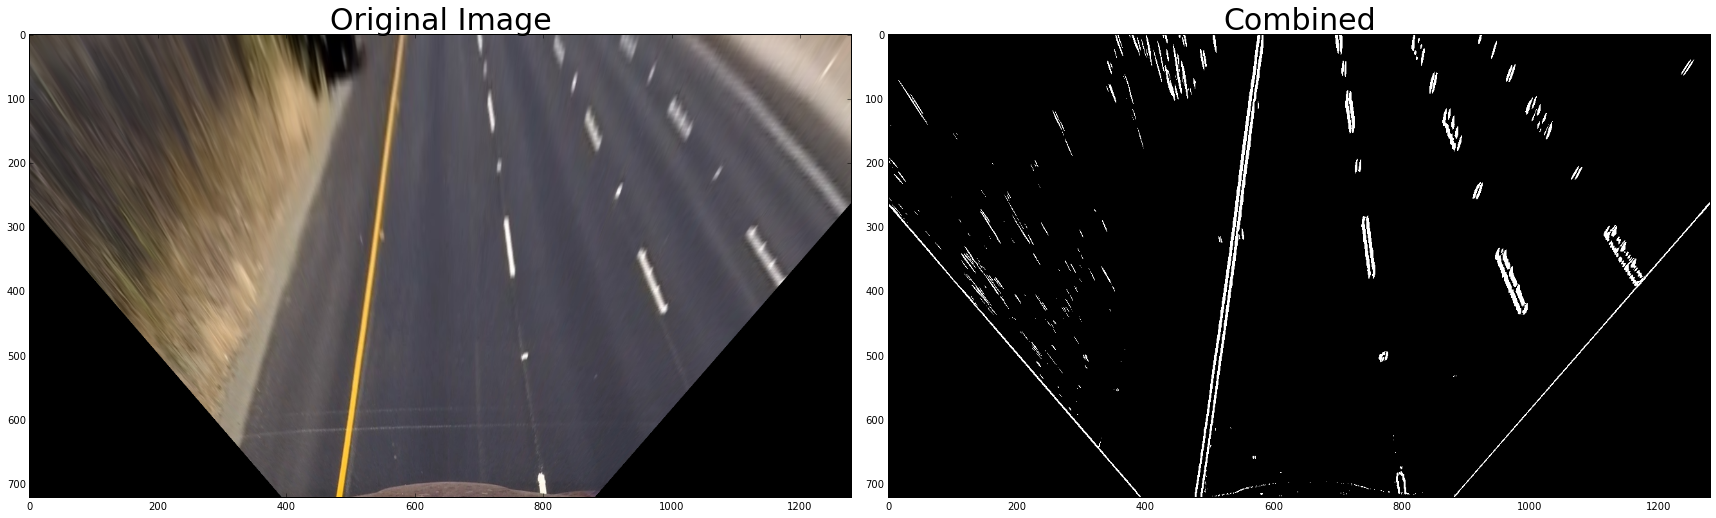

In [231]:
combined = np.zeros_like(dir_binary)
combined[(sobelabs_unwarp_x == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(unwarped)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined', fontsize=30)

In [232]:
#function for thresholding the S-channel of HLS
def hls_sthresh(img, thresh=(120, 255)):
    #Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #Apply threshold to S channel
    binary_output = np.zeros_like(hls[:,:,2])
    binary_output[(hls[:,:,2] > thresh[0]) & (hls[:,:,2] <= thresh[1])] = 1
    return binary_output

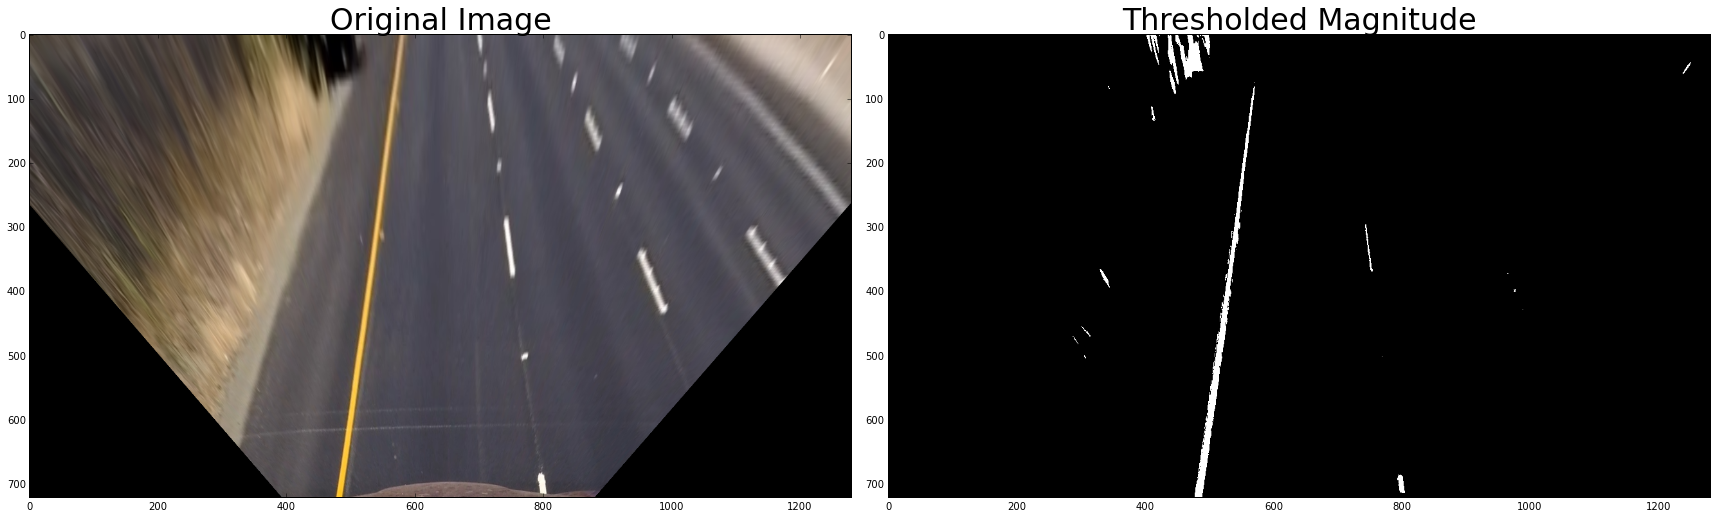

In [233]:
binary_sthresh = hls_sthresh(unwarped)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(unwarped)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(binary_sthresh, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=30)

In [234]:
#function for thresholding the L-channel of HLS
def hls_lthresh(img, thresh=(220, 255)):
    #Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
#     hls_l = hls_l*(255/np.max(hls_l))
    #Apply a threshold to the L channel
    binary_output = np.zeros_like(hls_l)
    binary_output[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

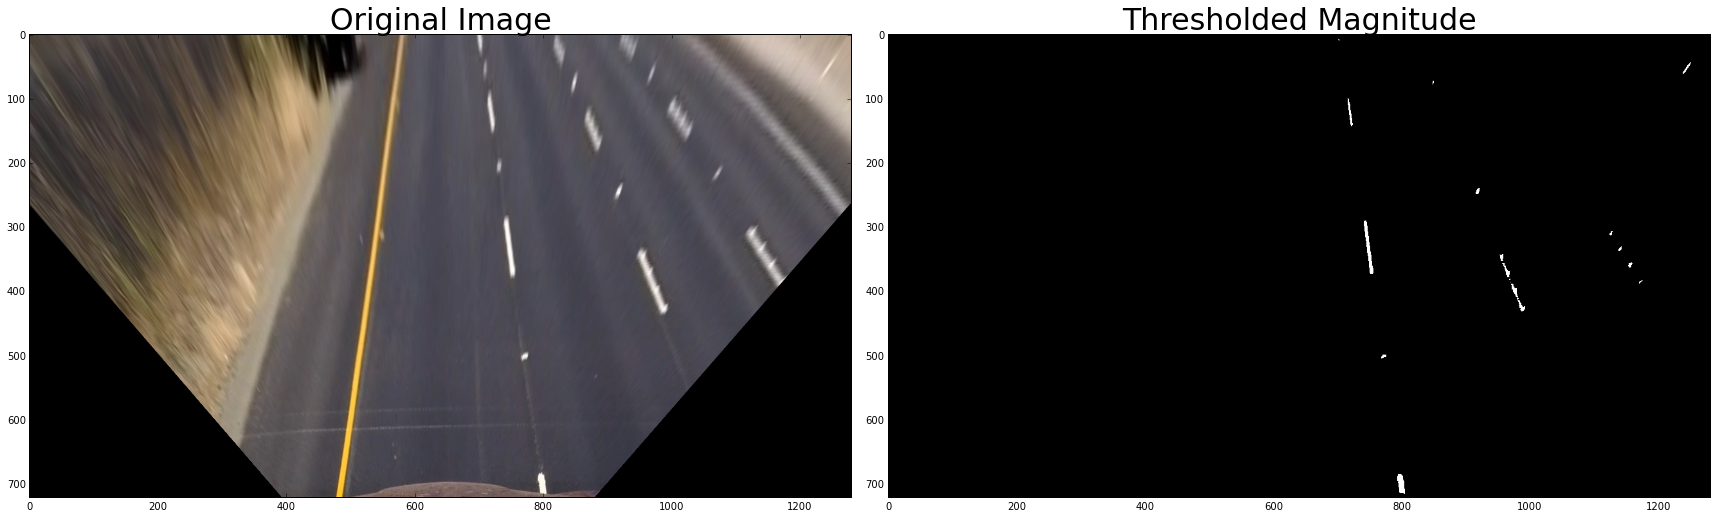

In [235]:
binary_lthresh = hls_lthresh(unwarped)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(unwarped)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(binary_lthresh, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=30)

## Choosing the best way to binarize

In [236]:
def binarize(img, s_thresh=(120, 255), sx_thresh=(20, 255),l_thresh=(40,255)):   
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    
    #separate S and L channels
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    sobel = cv2.Sobel(l_channel, cv2.CV_64F, 1,0)
    mag = np.absolute(sobel)
    scaled_sobel = np.uint8(255*mag/np.max(mag))
    grad_sx_binary =  np.zeros_like(scaled_sobel)
    grad_sx_binary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    channels = 255*np.dstack(( l_binary, grad_sx_binary, s_binary)).astype('uint8')        
    binary = np.zeros_like(grad_sx_binary)
    binary[((l_binary == 1) & (s_binary == 1) | (grad_sx_binary==1))] = 1
    binary = 255*np.dstack((binary,binary,binary)).astype('uint8')            
    return  binary

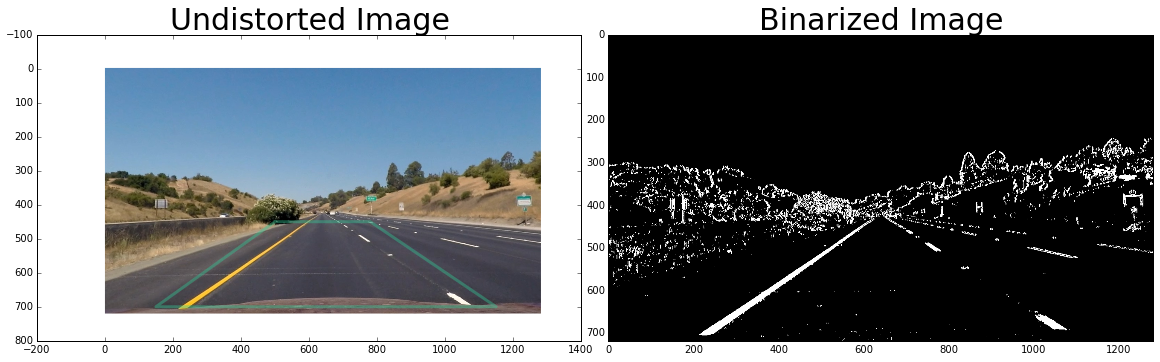

In [237]:
img = test_undistorted_rgb[0]
dir_binary = binarize(img)

# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='#33cc99', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(dir_binary, cmap="gray")
ax2.set_title('Binarized Image', fontsize=30)

In [238]:
binarize_images = []
for image in test_undistorted_rgb:
    binarize_images.append(binarize(image))

## Perspective Transform

In [239]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def image_warp(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M


In [241]:
#source and destination points for transform
sample_img = binarize_images[0]

src = np.float32([(500,450),
                  (780,450), 
                  (150,700), 
                  (1150,700)])
dst = np.float32([(450,0),
                  (sample_img.shape[1]-450,0),
                  (450,sample_img.shape[0]),
                  (sample_img.shape[1]-450,sample_img.shape[0])])


In [242]:
warped_sample, M = image_warp(binarize_images[0], src, dst)

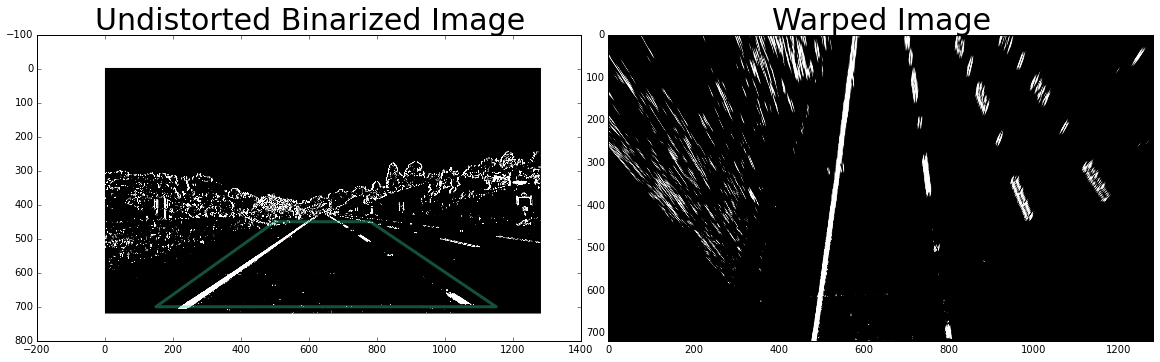

In [245]:
# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(binarize_images[0])
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='#33cc99', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_title('Undistorted Binarized Image', fontsize=30)
ax2.imshow(warped_sample)
ax2.set_title('Warped Image', fontsize=30)

In [246]:
#all images unwarped
warped_images = []
for image in binarize_images:
    warped, M = image_warp(image, src, dst)
    warped_images.append(warped)

## Visualize the transformed image in various color spaces i.e. RGB, HLS, HSV

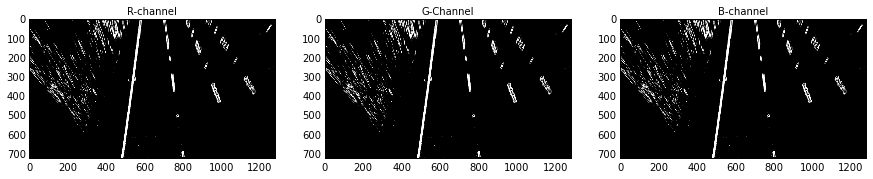

In [247]:
# Visualize RGB color space channels
channel_R = warped_sample[:,:,0]
channel_G = warped_sample[:,:,1]
channel_B = warped_sample[:,:,2]

fig, axs = plt.subplots(1,3, figsize=(15, 10))
axs = axs.ravel()
axs[0].imshow(channel_R, cmap='gray')
axs[0].set_title('R-channel', fontsize=10)
axs[1].imshow(channel_G, cmap='gray')
axs[1].set_title('G-Channel', fontsize=10)
axs[2].imshow(channel_B, cmap='gray')
axs[2].set_title('B-channel', fontsize=10)

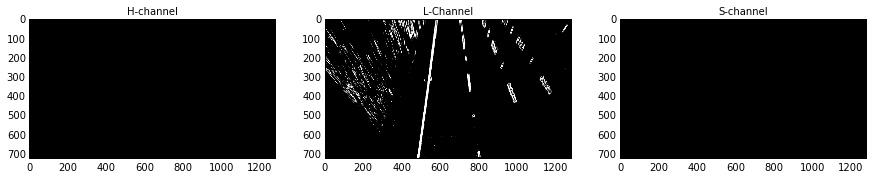

In [248]:
# Visualize HLS color space channels
warped_hls = cv2.cvtColor(warped_sample, cv2.COLOR_RGB2HLS)
channel_H = warped_hls[:,:,0]
channel_L = warped_hls[:,:,1]
channel_S = warped_hls[:,:,2]

fig, axs = plt.subplots(1,3, figsize=(15, 10))
axs = axs.ravel()
axs[0].imshow(channel_H, cmap='gray')
axs[0].set_title('H-channel', fontsize=10)
axs[1].imshow(channel_L, cmap='gray')
axs[1].set_title('L-Channel', fontsize=10)
axs[2].imshow(channel_S, cmap='gray')
axs[2].set_title('S-channel', fontsize=10)

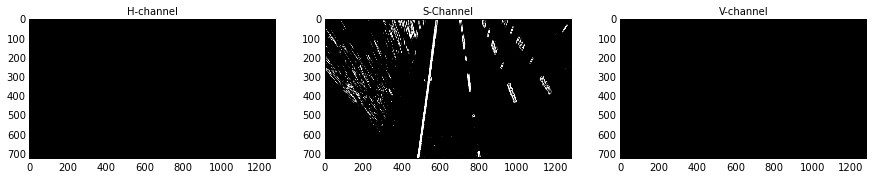

In [249]:
# Visualize HSV color space channels
warped_hsv = cv2.cvtColor(warped_sample, cv2.COLOR_RGB2HSV)
channel_H = warped_hsv[:,:,0]
channel_S = warped_hsv[:,:,1]
channel_V = warped_hsv[:,:,2]

fig, axs = plt.subplots(1,3, figsize=(15, 10))
axs = axs.ravel()
axs[0].imshow(channel_H, cmap='gray')
axs[0].set_title('H-channel', fontsize=10)
axs[1].imshow(channel_L, cmap='gray')
axs[1].set_title('S-Channel', fontsize=10)
axs[2].imshow(channel_S, cmap='gray')
axs[2].set_title('V-channel', fontsize=10)

In [250]:
def region_mask(img):
    shape = img.shape
    vertices = np.array([[(350,0), ()]],dtype=np.int32)
    
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

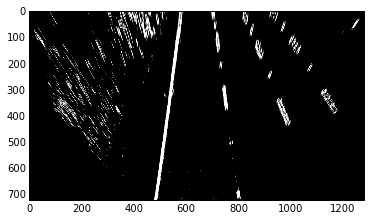

In [251]:
plt.imshow(region_mask(warped_images[0]))